# 12. Seq2seq으로 번역기 만들기 [프로젝트]
<br>

#### 라이브러리 import 및 버전 확인
<br>

In [1]:
import pandas
import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


<br>

## Step 1. 데이터 가져오기
<br>

In [2]:
# 데이터 저장 위치 확인

In [3]:
import os

file_path = os.getenv('HOME')+'/aiffel/s2s_translation'
print(file_path)

/aiffel/aiffel/s2s_translation


In [4]:
# 주어진 경로에 있는 파일 및 폴더 목록 가져오기
file_list = os.listdir(file_path)

In [5]:
# 파일 및 폴더 목록 출력
for file in file_list:
    print(file)

korean-english-park.train.en
korean-english-park.train.ko
korean-english-park.train.tar.gz
.ipynb_checkpoints


<br>

In [6]:
# 압축 해제할 파일의 경로
tar_gz_path = os.path.join(file_path, 'korean-english-park.train.tar.gz')

In [7]:
# 압축 해제
import tarfile

with tarfile.open(tar_gz_path, 'r:gz') as tar:
    tar.extractall(path=file_path)

<br>

In [8]:
file_list = os.listdir(file_path)

In [9]:
for file in file_list:
    print(file)

korean-english-park.train.en
korean-english-park.train.ko
korean-english-park.train.tar.gz
.ipynb_checkpoints


<br>

In [10]:
# 데이터 가져오기

In [11]:
def load_file(file_path, file_name):
    # 파일 경로
    load_file_path = os.path.join(file_path, file_name)

    # 파일 로드
    with open(load_file_path, 'r', encoding='utf-8') as f:
        raw = f.read().splitlines()
        
    print("Data Size:", len(raw))
    print("Example:")
    
    for sen in raw[0:100][::20]: 
        print(">>", sen)
    
    return raw

In [12]:
raw_kor = load_file(file_path, 'korean-english-park.train.ko')

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [13]:
raw_en= load_file(file_path, 'korean-english-park.train.en')

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


<br><br>

## Step 2. 데이터 정제하기
<br>

#### 1. 중복 데이터 제거

+ set 데이터형 활용
+ 데이터의 병렬 쌍 유지
+ 중복을 제거한 데이터를 cleaned_corpus 에 저장

In [14]:
# 두 데이터 셋의 병렬 쌍을 유지하며 중복 제거하기

In [15]:
unique_data = set()
filtered_kor = []
filtered_en = []

for kor_sentence, en_sentence in zip(raw_kor, raw_en):
    if (kor_sentence, en_sentence) not in unique_data:
        filtered_kor.append(kor_sentence)
        filtered_en.append(en_sentence)
        unique_data.add((kor_sentence, en_sentence))

In [16]:
print(f"Original Korean data size: {len(raw_kor)}")
print(f"Filtered Korean data size: {len(filtered_kor)}")
print(f"Original English data size: {len(raw_en)}")
print(f"Filtered English data size: {len(filtered_en)}")

Original Korean data size: 94123
Filtered Korean data size: 78968
Original English data size: 94123
Filtered English data size: 78968


In [17]:
cleaned_corpus_kor = filtered_kor
cleaned_corpus_en = filtered_en

In [18]:
print(len(cleaned_corpus_kor))
print(len(cleaned_corpus_en))

78968
78968


In [19]:
cleaned_corpus_kor[10]

'약 200600밀리그램의, 비슷한 분량의 카페인은 또한 육체적 지구력을 강화시키는 데 효과적인 것 같으며, 특히 고도가 높은 곳에서 약해진 육체적 지구력을 일부 회복시켜주는 데 유용하다는 것이 이번 연구에서 밝혀졌다.'

In [20]:
cleaned_corpus_en[1000]

'/ But these days / that rationale is being questioned.'

<br>

#### 2. 특수문자 제거 및 시작/종료 토큰 추가
<br>

In [21]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    
    # 특수문자 양쪽에 공백을 추가하지 않고, 특수문자 앞에만 공백을 추가
    sentence = re.sub(r"([?.!,])", r"\1 ", sentence)
    # 두 개 이상의 공백을 하나의 공백으로 변경
    sentence = re.sub(r'[" "]+', " ", sentence)
    # a-zA-Z?.! 와 한글을 제외한 모든 문자를 공백으로 변경
    sentence = re.sub(r"[^a-zA-Z?.!ㄱ-ㅎㅏ-ㅣ가-힣]+", " ", sentence)
    
    sentence = sentence.strip()
    
    if s_token:
        sentence = '<start> ' + sentence
    if e_token:
        sentence += ' <end>'
    
    return sentence

In [22]:
import re

enc_corpus = []
dec_corpus = []

for kor, en in zip(cleaned_corpus_kor, cleaned_corpus_en):    
    enc_corpus.append(preprocess_sentence(kor))
    dec_corpus.append(preprocess_sentence(en, s_token=True, e_token=True))

In [23]:
print('korean data size:', len(enc_corpus))
print('english data size:', len(dec_corpus))
print("Korean:", enc_corpus[1000])   
print("English:", dec_corpus[1000])  

korean data size: 78968
english data size: 78968
Korean: 그러나 요즈음에 그러한 이론적 해석이 의문시되고 있다.
English: <start> but these days that rationale is being questioned. <end>


<br>

#### 3. 데이터 토큰화
+ split() 함수를 이용
+ 한글 토큰화는 KoNLPy의 mecab 클래스를 사용
+ 토큰의 길이가 40 이하인 데이터를 선별해 eng_corpus와 kor_corpus를 구함.

In [24]:
from konlpy.tag import Mecab

mecab = Mecab()

kor_corpus = []
eng_corpus = []

for pair in zip(enc_corpus, dec_corpus):
    kor, en = pair

    # 토큰화를 통해 문장 내 토큰의 개수를 확인합니다.
    if len(mecab.morphs(kor)) <= 40 and len(en.split()) <= 40:
        kor_corpus.append(kor)
        eng_corpus.append(en)

In [25]:
print(len(kor_corpus))
print(len(eng_corpus))

65009
65009


In [26]:
print("한글:", kor_corpus[1000])   
print("영어:", eng_corpus[1000])  

한글: 자신과 상대방의 감정을 인지하고 이를 통제하는 것과 같은 핵심적인 사업 기술을 터득하기란 어려운 과정이다.
영어: <start> acquiring key business skills such as perceiving and controlling emotions in oneself and others is a subtle process. <end>


<br><br>

## Step 3. 데이터 토큰화
<br>

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 40000
def tokenize(corpus, lang="kor"):
    if lang == "kor":
        mecab = Mecab()
        corpus = [" ".join(mecab.morphs(sentence)) for sentence in corpus]
    
    tokenizer = Tokenizer(filters='', oov_token='<OOV>', num_words=num_words)
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [28]:
enc_tensor, enc_tokenizer = tokenize(kor_corpus, lang="kor")
dec_tensor, dec_tokenizer = tokenize(eng_corpus, lang="en")

In [29]:
print(len(enc_tensor))
print(len(dec_tensor))
print(enc_tokenizer)
print(dec_tokenizer)

65009
65009


<br>

In [30]:
# train_test_split을 활용해서 훈련 데이터와 검증 데이터로 분리하기

In [31]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

In [32]:
print("Korean Train:", enc_train.shape)
print("Korean Validation:", enc_val.shape)
print("English Train:", dec_train.shape)
print("English Validation:", dec_val.shape)

Korean Train: (52007, 40)
Korean Validation: (13002, 40)
English Train: (52007, 40)
English Validation: (13002, 40)


<br><br>

## Step 4. 모델 설계
<br>

In [33]:
# 각각 1개의 GRU을 갖는 Encoder-Decoder 구조 설계

In [34]:
import tensorflow as tf

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [35]:
# Encoder 클래스 설계

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True, 
                                       dropout=0.5)  # Dropout 추가

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [37]:
# Decoder 클래스를 설계

In [38]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [39]:
len(enc_tokenizer.index_word)

44908

In [40]:
len(dec_tokenizer.index_word)

49310

<br>

In [41]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 1024)
Decoder Output: (64, 49311)
Decoder Hidden State: (64, 1024)
Attention: (64, 40, 1)


<br><br>

## Step 5. 훈련하기
<br>

#### Optimizer & Loss

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [43]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [44]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

<br>

#### train_step

In [45]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        # 1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
        enc_out = encoder(src)
        # 2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의
        h_dec = enc_out[:, -1]
        
        # 3. Decoder에 입력으로 전달할 <start> 토큰 문장 생성
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            # 4. <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            
            # 5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    
    # Gradient Clipping
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, 5)
    
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

<br>

In [46]:
# eval_step() 정의하기

In [47]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

<br>

In [48]:
# 모델 학습 + 모델 평가

In [49]:
# train_step() 이후 eval_step() 진행하도록 소스 수정하기

In [50]:
import random
from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 204/204 [00:46<00:00,  4.37it/s, Test Loss 2.9443]


<br>

## 성능 평가하기
<br>

In [3]:
# 번역 성능 평가

In [113]:
import numpy as np

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [100]:
result, sentence, attention = evaluate("나는 요즘 고민이 많아", encoder, decoder)

In [101]:
print('입력 문장: %s' % (sentence))
print('예측된 번역: {}'.format(result))

입력 문장: 나는 요즘 고민이 많아
예측된 번역: we re election <end> 


<br>

In [102]:
# Attention Map 시각화

In [103]:
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)

In [104]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

/tmp/ipykernel_47/1137553069.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_47/1137553069.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


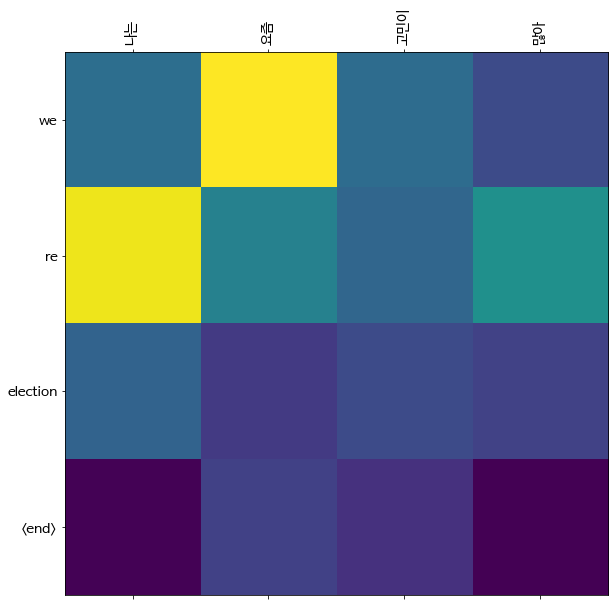

In [105]:
attention = attention[:len(result.split()), :len(sentence.split())]
plot_attention(attention, sentence.split(), result.split(' '))

<br>

In [106]:
result, sentence, attention = evaluate("그는 대통령 선거에 당선되었어.", encoder, decoder)

In [107]:
print('입력 문장: %s' % (sentence))
print('예측된 번역: {}'.format(result))

입력 문장: 그는 대통령 선거에 당선되었어.
예측된 번역: president roh moo hyun s president <end> 


/tmp/ipykernel_47/1137553069.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_47/1137553069.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


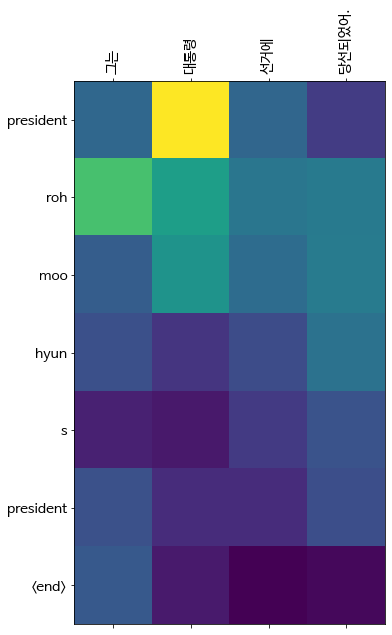

In [108]:
attention = attention[:len(result.split()), :len(sentence.split())]
plot_attention(attention, sentence.split(), result.split(' '))

<br>

In [122]:
result, sentence, attention = evaluate('특히 고도가 높은 곳에서 약해진 육체적 지구력을 일부 회복시켜주는 데 유용하다는 것이', encoder, decoder)

In [123]:
print('입력 문장: %s' % (sentence))
print('예측된 번역: {}'.format(result))

입력 문장: 특히 고도가 높은 곳에서 약해진 육체적 지구력을 일부 회복시켜주는 데 유용하다는 것이
예측된 번역: the korea times reports korea s consumer confidence has seen concerns about the korean peninsula. <end> 


/tmp/ipykernel_47/1137553069.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_47/1137553069.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


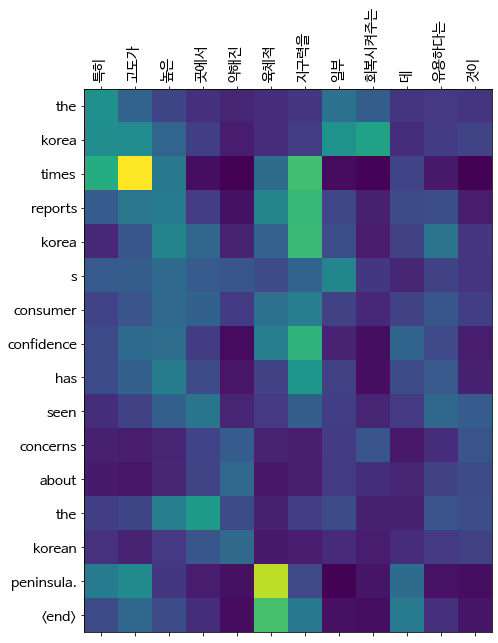

In [124]:
attention = attention[:len(result.split()), :len(sentence.split())]
plot_attention(attention, sentence.split(), result.split(' '))

<br>

In [125]:
result, sentence, attention = evaluate('한반도의 평화를 위해 북한의 핵무장을 반대한다.', encoder, decoder)

In [126]:
print('입력 문장: %s' % (sentence))
print('예측된 번역: {}'.format(result))

입력 문장: 한반도의 평화를 위해 북한의 핵무장을 반대한다.
예측된 번역: he adds to the korean peninsula. <end> 


/tmp/ipykernel_47/1137553069.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_47/1137553069.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


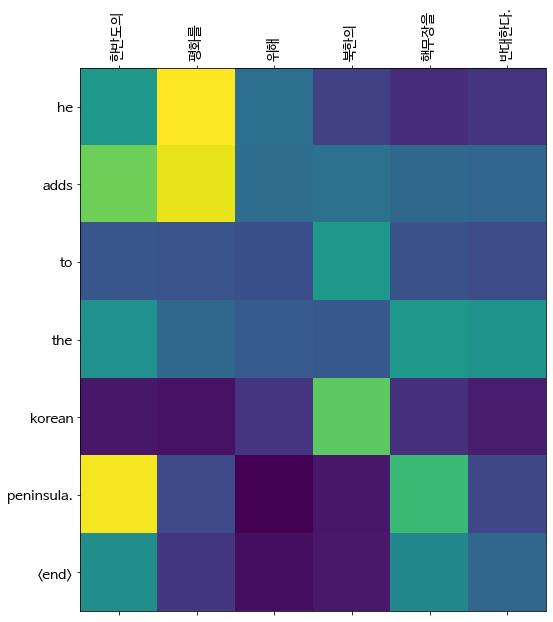

In [127]:
attention = attention[:len(result.split()), :len(sentence.split())]
plot_attention(attention, sentence.split(), result.split(' '))

<br><br>

## 12-2. 프로젝트 제출
<br>

### 루브릭
<br>

#### 평가문항 및 상세기준
<br>

##### 1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.

구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.

<br>

##### 2. Attentional Seq2seq 모델이 정상적으로 구동된다.

seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.

<br>

##### 3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.

테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.